In [26]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt


class Renderer:
    def __init__(self, reward_map, goal_state, wall_state):
        self.reward_map = reward_map
        self.goal_state = goal_state
        self.wall_state = wall_state
        self.ys = len(self.reward_map)
        self.xs = len(self.reward_map[0])

        self.ax = None
        self.fig = None
        self.first_flg = True

    def set_figure(self, figsize=None):
        fig = plt.figure(figsize=figsize)
        self.ax = fig.add_subplot(111)
        ax = self.ax
        ax.clear()
        ax.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
        ax.set_xticks(range(self.xs))
        ax.set_yticks(range(self.ys))
        ax.set_xlim(0, self.xs)
        ax.set_ylim(0, self.ys)
        ax.grid(True)

    def render_v(self, v=None, policy=None, print_value=True):
        self.set_figure()

        ys, xs = self.ys, self.xs
        ax = self.ax

        if v is not None:
            color_list = ['red', 'white', 'green']
            cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
                'colormap_name', color_list)

            # dict -> ndarray
            v_dict = v
            v = np.zeros(self.reward_map.shape)
            for state, value in v_dict.items():
                v[state] = value

            vmax, vmin = v.max(), v.min()
            vmax = max(vmax, abs(vmin))
            vmin = -1 * vmax
            vmax = 1 if vmax < 1 else vmax
            vmin = -1 if vmin > -1 else vmin

            ax.pcolormesh(np.flipud(v), cmap=cmap, vmin=vmin, vmax=vmax)

        for y in range(ys):
            for x in range(xs):
                state = (y, x)
                r = self.reward_map[y, x]
                if r != 0 and r is not None:
                    txt = 'R ' + str(r)
                    if state == self.goal_state:
                        txt = txt + ' (GOAL)'
                    ax.text(x+.1, ys-y-0.9, txt)

                if (v is not None) and state != self.wall_state:
                    if print_value:
                        offsets = [(0.4, -0.15), (-0.15, -0.3)]
                        key = 0
                        if v.shape[0] > 7: key = 1
                        offset = offsets[key]
                        ax.text(x+offset[0], ys-y+offset[1], "{:12.2f}".format(v[y, x]))

                if policy is not None and state != self.wall_state:
                    actions = policy[state]
                    max_actions = [kv[0] for kv in actions.items() if kv[1] == max(actions.values())]

                    arrows = ["↑", "↓", "←", "→"]
                    offsets = [(0, 0.1), (0, -0.1), (-0.1, 0), (0.1, 0)]
                    for action in max_actions:
                        arrow = arrows[action]
                        offset = offsets[action]
                        if state == self.goal_state:
                            continue
                        ax.text(x+0.45+offset[0], ys-y-0.5+offset[1], arrow)

                if state == self.wall_state:
                    ax.add_patch(plt.Rectangle((x,ys-y-1), 1, 1, fc=(0.4, 0.4, 0.4, 1.)))
        plt.show()

    def render_q(self, q, show_greedy_policy=True):
        self.set_figure()

        ys, xs = self.ys, self.xs
        ax = self.ax
        action_space = [0, 1, 2, 3]

        qmax, qmin = max(q.values()), min(q.values())
        qmax = max(qmax, abs(qmin))
        qmin = -1 * qmax
        qmax = 1 if qmax < 1 else qmax
        qmin = -1 if qmin > -1 else qmin


        color_list = ['red', 'white', 'green']
        cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
            'colormap_name', color_list)

        for y in range(ys):
            for x in range(xs):
                for action in action_space:
                    state = (y, x)
                    r = self.reward_map[y, x]
                    if r != 0 and r is not None:
                        txt = 'R ' + str(r)
                        if state == self.goal_state:
                            txt = txt + ' (GOAL)'
                        ax.text(x+.05, ys-y-0.95, txt)

                    if state == self.goal_state:
                        continue

                    tx, ty = x, ys-y-1

                    action_map = {
                        0: ((0.5+tx, 0.5+ty), (tx+1, ty+1), (tx, ty+1)),
                        1: ((tx, ty), (tx+1, ty), (tx+0.5, ty+0.5)),
                        2: ((tx, ty), (tx+0.5, ty+0.5), (tx, ty+1)),
                        3: ((0.5+tx, 0.5+ty), (tx+1, ty), (tx+1, ty+1)),
                    }
                    offset_map = {
                        0: (0.1, 0.8),
                        1: (0.1, 0.1),
                        2: (-0.2, 0.4),
                        3: (0.4, 0.4),
                    }
                    if state == self.wall_state:
                        ax.add_patch(plt.Rectangle((tx, ty), 1, 1, fc=(0.4, 0.4, 0.4, 1.)))
                    elif state in self.goal_state:
                        ax.add_patch(plt.Rectangle((tx, ty), 1, 1, fc=(0., 1., 0., 1.)))
                    else:

                        tq = q[(state, action)]
                        color_scale = 0.5 + (tq / qmax) / 2  # normalize: 0.0-1.0

                        poly = plt.Polygon(action_map[action],fc=cmap(color_scale))
                        ax.add_patch(poly)

                        offset= offset_map[action]
                        ax.text(tx+offset[0], ty+offset[1], "{:12.2f}".format(tq))
        plt.show()

        if show_greedy_policy:
            policy = {}
            for y in range(self.ys):
                for x in range(self.xs):
                    state = (y, x)
                    qs = [q[state, action] for action in range(4)]  # action_size
                    max_action = np.argmax(qs)
                    probs = {0:0.0, 1:0.0, 2:0.0, 3:0.0}
                    probs[max_action] = 1
                    policy[state] = probs
            self.render_v(None, policy)

In [27]:
import numpy as np


class GridWorld:
    def __init__(self):
        self.action_space = [0, 1, 2, 3]  # 행동 공간(가능한 행동들)
        self.action_meaning = {  # 행동의 의미
            0: "UP",
            1: "DOWN",
            2: "LEFT",
            3: "RIGHT",
        }

        self.reward_map = np.array(  # 보상 맵(각 좌표의 보상 값)
            [[0, 0, 0, 1.0],
             [0, None, 0, -1.0],
             [0, 0, 0, 0]]
        )
        self.goal_state = (0, 3)    # 목표 상태(좌표)
        self.wall_state = (1, 1)    # 벽 상태(좌표)
        self.start_state = (2, 0)   # 시작 상태(좌표)
        self.agent_state = self.start_state   # 에이전트 초기 상태(좌표)

    @property
    def height(self):
        return len(self.reward_map)

    @property
    def width(self):
        return len(self.reward_map[0])

    @property
    def shape(self):
        return self.reward_map.shape

    def actions(self):
        return self.action_space

    def states(self):
        for h in range(self.height):
            for w in range(self.width):
                yield (h, w)

    def next_state(self, state, action):
        # 이동 위치 계산
        action_move_map = [(-1, 0), (1, 0), (0, -1), (0, 1)]
        move = action_move_map[action]
        next_state = (state[0] + move[0], state[1] + move[1])
        ny, nx = next_state

        # 이동한 위치가 그리드 월드의 테두리 밖이나 벽인가?
        if nx < 0 or nx >= self.width or ny < 0 or ny >= self.height:
            next_state = state
        elif next_state == self.wall_state:
            next_state = state

        return next_state  # 다음 상태 반환

    def reward(self, state, action, next_state):
        return self.reward_map[next_state]

    def reset(self):
        self.agent_state = self.start_state
        return self.agent_state

    def step(self, action):
        state = self.agent_state
        next_state = self.next_state(state, action)
        reward = self.reward(state, action, next_state)
        done = (next_state == self.goal_state)

        self.agent_state = next_state
        return next_state, reward, done

    def render_v(self, v=None, policy=None, print_value=True):
        renderer = Renderer(self.reward_map, self.goal_state,
                                          self.wall_state)
        renderer.render_v(v, policy, print_value)

    def render_q(self, q=None, print_value=True):
        renderer = Renderer(self.reward_map, self.goal_state,
                                          self.wall_state)
        renderer.render_q(q, print_value)


In [28]:
ps = {2:1/36, 3:2/36, 4:3/36, 5:4/36, 6:5/36, 7:6/36,8:5/36, 9:4/36, 10:3/36, 11:2/36, 12:1/36}

V = 0

for x, p in ps.items() :
    V += x * p
    
print(V)

6.999999999999999


In [29]:
def sample(dices = 2) :
    x = 0
    for _ in range(dices) :
        x += np.random.choice(np.arange(1, 7))
    return x

In [30]:
trial = 1000
samples = []

for _ in range(trial) :
    s = sample()
    samples.append(s)
    
V = sum(samples) / len(samples)
print(V)

6.921


In [39]:
env = GridWorld()
action = 0
next_state, reward, done = env.step(action)

print(f"next_state : {next_state}, reward : {reward}, done : {done}")

next_state : (1, 0), reward : 0, done : False


In [ ]:
from collections import defaultdict

class RandomAgent :
    def __init__(self):
        self.gamma = 0.9
        self.action_size = 4
        
        random_actions = {0 : 0.25, 1 : 0.25, 2 : 0.25, 3 : 0.25}
        self.pi = defaultdict(lambda : random_actions)
        self.V = defaultdict(lambda : 0)
        self.cnts = defaultdict(lambda : 0)
        self.memory = []
        
    def get_action(self, state) :
        action_probs = self.pi[state]
        actions = list(action_probs.keys())
        probs = list(action_probs.values())
        
        return np.random.choice(actions, p = probs)
    
    def add(self, state, action, reward) :
        data = (state, action, reward)
        self.memory.append(data)
        
    def reset(self) :
        self.memory.clear()
        
    def eval(self) :
        G = 0
        for data in reversed(self.memory) :
            state, action, reward = data
            G = self.gamma * G + reward
            self.cnts[state] += 1
            self.V[state] += (G - self.V[state]) / self.cnts[state]

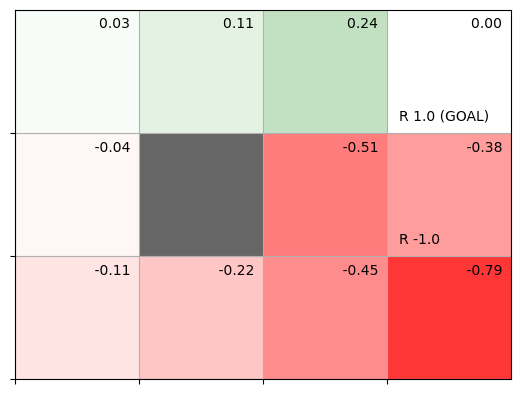

defaultdict(<function RandomAgent.__init__.<locals>.<lambda> at 0x134017c40>, {(1, 3): -0.38291534248125847, (1, 2): -0.5121449538031696, (2, 2): -0.45266801952660785, (2, 1): -0.22141645090548578, (2, 0): -0.1061422742603761, (1, 0): -0.036700327768505625, (0, 2): 0.23932585476920593, (0, 0): 0.02528932908477702, (0, 1): 0.10825837784522863, (2, 3): -0.785836372581307})


In [46]:
env = GridWorld()
agent = RandomAgent()

episodes = 1000

for episode in range(episodes) :
    state = env.reset()
    agent.reset()
    
    while True :
        action = agent.get_action(state)
        next_state, reward, done = env.step(action)
        
        agent.add(state, action, reward)
        
        if done :
            agent.eval()
            break
        
        state = next_state

env.render_v(agent.V)
print(agent.V)

In [67]:
class McAgent :
    def __init__(self):
        self.gamma = 0.9
        self.epsilon = 0.1
        self.alpha = 0.1
        self.action_size = 4
        
        random_actions = {0 : 0.25, 1 : 0.25, 2 : 0.25, 3 : 0.25}
        self.pi = defaultdict(lambda : random_actions)
        self.Q = defaultdict(lambda : 0)
        self.cnts = defaultdict(lambda : 0)
        self.memory = []
        
    def get_action(self, state) :
        action_probs = self.pi[state]
        actions = list(action_probs.keys())
        probs = list(action_probs.values())
        
        return np.random.choice(actions, p=probs)
    
    def add(self, state, action, reward) :
        data = (state, action, reward)
        self.memory.append(data)
        
    def reset(self) :
        self.memory.clear()
        
    def update(self) :
        G = 0
        for data in reversed(self.memory) :
            state, action, reward = data
            G = self.gamma * G + reward
            key = (state, action)
            self.cnts[key] += 1
            # self.Q[key] += (G - self.Q[key]) / self.cnts[key]
            self.Q[key] += (G - self.Q[key]) * self.alpha
            self.pi[state] = greedy_probs(self.Q, state, self.epsilon)
            
def greedy_probs(Q, state, epsilon=0, action_size=4) :
    qs = [Q[(state, action)] for action in range(action_size)]
    max_action = np.argmax(qs)
    
    # action_probs = {action : 0.0 for action in range(action_size)}
    # action_probs[max_action] = 1
    
    base_prob = epsilon / action_size
    action_probs = {action : base_prob for action in range(action_size)}
    action_probs[max_action] += (1 - epsilon)
    
    return action_probs

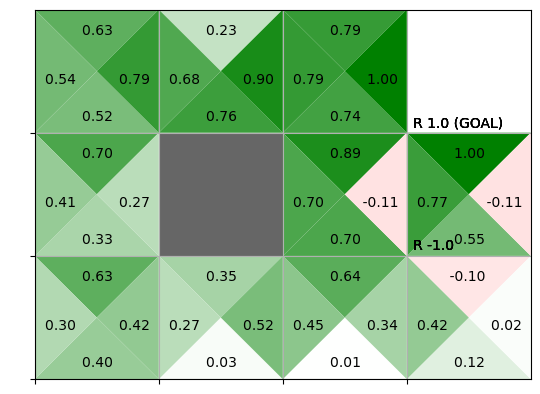

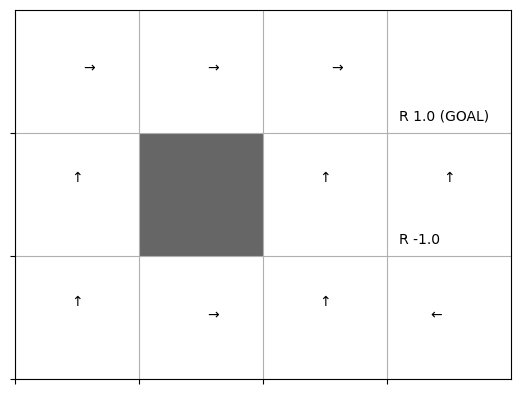

In [ ]:
env = GridWorld()
agent = McAgent()
episodes = 10000

for episode in range(episodes) :
    state = env.reset()
    agent.reset()
    
    while True :
        action = agent.get_action(state)
        next_state, reward, done = env.step(action)
        
        agent.add(state, action, reward)
        
        if (done) :
            agent.update()
            break
        
        state = next_state
        
env.render_q(agent.Q)